In [1]:
import numpy as np
import random
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import h3
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point, mapping, MultiPolygon
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt, radians, atan2
from geopy.distance import geodesic

# **GET POIs**

In [2]:
def get_poi_coords(place_name, tags, epsg_code):
    gdf = ox.features_from_place(place_name, tags)

    # Convert to centroid points (geometries → point)
    gdf_points = gdf.copy()
    gdf_points["geometry"] = gdf_points["geometry"].centroid

    # Optional: Get lat/lng
    gdf_latlon = gdf_points.to_crs(epsg=epsg_code)
    gdf_latlon["lat"] = gdf_latlon.geometry.y
    gdf_latlon["lon"] = gdf_latlon.geometry.x
    
    return gdf_latlon[['geometry', 'building', 'name', 'addr:city',
                      'addr:housenumber', 'addr:postcode', 'addr:state',
                      'addr:street', 'building:levels', 'building:use',
                      'lat', 'lon']]

In [3]:
def plot_poi(gdf_poi, epsg_code=3857):
    # Project for basemap and plot
    gdf_points = gdf_poi.copy()
    gdf_points = gdf_points.to_crs(epsg=epsg_code)

    fig, ax = plt.subplots(figsize=(5, 5))
    gdf_points.plot(ax=ax, color="red", markersize=10)

    # Add background basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.axis("off")
    plt.tight_layout()
    plt.show()

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


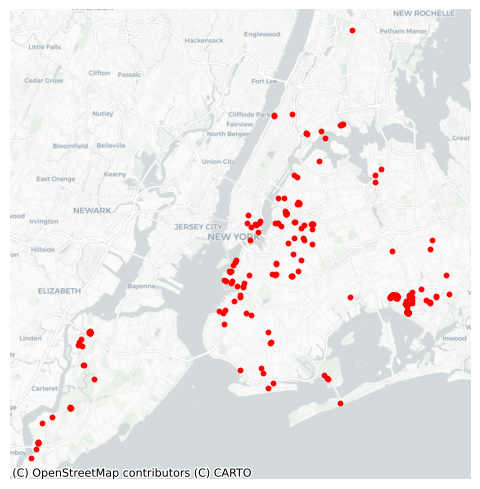

In [4]:
place_name = "New York City, New York, USA"
# tags = {"building": "warehouse", "landuse": "industrial"}
tags = {
    "building": [
        "warehouse",
        "storage_tank",
        "storage",
        "depot",
        "hangar"
    ]
}
epsg_code = 4326

gdf_warehouse = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_warehouse)

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


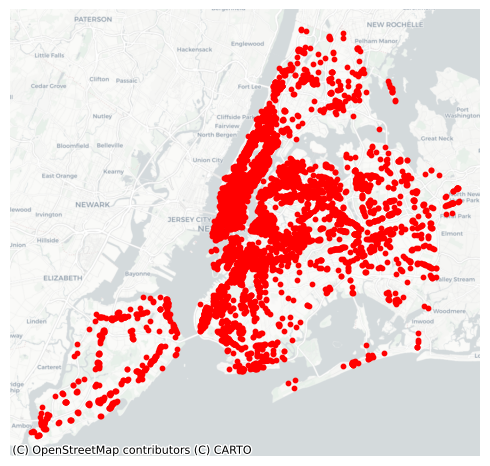

In [5]:
place_name = "New York City, New York, USA"
tags = {"amenity": "restaurant"}
epsg_code = 4326

gdf_restaurant = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_restaurant)

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


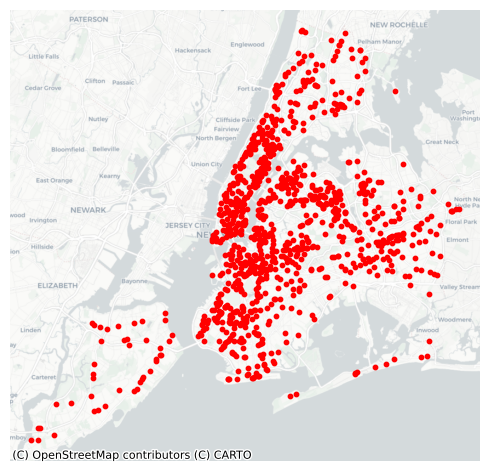

In [6]:
place_name = "New York City, New York, USA"
tags = {"shop": ["supermarket", "grocery"]}
epsg_code = 4326

gdf_grocery = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_grocery)

In [7]:
gdf_warehouse.head()

geometry      building name addr:city  \
element  id                                                                   
relation 3778810     POINT (-73.7998 40.66096)        hangar  DAL       NaN   
way      157929440  POINT (-73.80237 40.64567)  storage_tank  NaN       NaN   
         157929443   POINT (-73.8012 40.64479)  storage_tank  NaN       NaN   
         157929446  POINT (-73.80172 40.64573)  storage_tank  NaN       NaN   
         157929450  POINT (-73.80232 40.64548)  storage_tank  NaN       NaN   

                   addr:housenumber addr:postcode addr:state addr:street  \
element  id                                                                
relation 3778810                NaN           NaN        NaN         NaN   
way      157929440              NaN           NaN        NaN         NaN   
         157929443              NaN           NaN        NaN         NaN   
         157929446              NaN           NaN        NaN         NaN   
         157929450              NaN           NaN        NaN         NaN   

                   building:levels building:use        lat        lon  
element  id                                                            
relation 3778810               NaN          NaN  40.660959 -73.799798  
way      157929440             NaN          NaN  40.645673 -73.802372  
         157929443             NaN          NaN  40.644789 -73.801196  
         157929446             NaN          NaN  40.645730 -73.801721  
         157929450             NaN          NaN  40.645481 -73.802323

In [8]:
def gdf_to_df(gdf, typ):
    # Create DataFrame directly from geometry coordinates and add the type column
    return pd.DataFrame({
        'type': typ,
        'lat': gdf.geometry.y,
        'lon': gdf.geometry.x
    })

# Convert each gdf
df_warehouse = gdf_to_df(gdf_warehouse, 'warehouse')
df_restaurant = gdf_to_df(gdf_restaurant, 'restaurant')
df_grocery = gdf_to_df(gdf_grocery, 'grocery')

# Combine all
poi_df = pd.concat([df_warehouse, df_restaurant, df_grocery], ignore_index=True)

poi_df.tail()


,type,lat,lon
8942,grocery,40.787478,-73.944369
8943,grocery,40.580073,-74.166639
8944,grocery,40.626805,-73.977110
8945,grocery,40.558996,-73.919957
8946,grocery,40.666045,-73.924558


In [9]:
len(gdf_warehouse), len(gdf_restaurant), len(gdf_grocery), len(poi_df)

(277, 7593, 1077, 8947)

# **DEFINE HEX GRID**

In [10]:
# city = gpd.read_file("nyc_boroughs.geojson")
# city_combined = city.dissolve()
# geometry = city_combined.geometry.values[0]

In [11]:
# polygons = geometry.geoms if geometry.geom_type == 'MultiPolygon' else [geometry]

# h3_polygons = []
# for poly in polygons:
#     # Exterior ring: convert (x, y) to [lat, lng]
#     exterior = [[y, x] for x, y in poly.exterior.coords]
#     # Interior rings (holes)
#     holes = [[[y, x] for x, y in ring.coords] for ring in poly.interiors]
#     h3_polygons.append({'outer': exterior, 'holes': holes})

In [12]:
### WITHOUT BUFFER:

# LatLngPoly = h3.LatLngPoly

# # Load and combine NYC polygons
# gdf = gpd.read_file("nyc_boroughs.geojson")
# geometry = gdf.dissolve().geometry.values[0]

# # Handle MultiPolygon or Polygon uniformly
# polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# # Convert polygons to LatLngPoly for H3
# latlng_polys = []
# for poly in polygons:
#     outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
#     latlng_polys.append(h3.LatLngPoly(outer_ring))

# # Collect all candidate H3 cells: base cells + neighbors
# all_candidate_cells = set()
# for shape in latlng_polys:
#     base_cells = h3.polygon_to_cells(shape, res=7)
#     candidate_cells = set(base_cells)
#     for cell in base_cells:
#         candidate_cells.update(h3.grid_ring(cell, 1))  # add neighbors (distance 1)
#     all_candidate_cells.update(candidate_cells)

# # Convert H3 cells to polygons for spatial filtering
# polygons = [
#     Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
#     for cell in all_candidate_cells
# ]

# # Create GeoDataFrame of candidate hex cells
# candidate_gdf = gpd.GeoDataFrame(
#     {'h3_index': list(all_candidate_cells), 'geometry': polygons},
#     crs='EPSG:4326'
# )

# # Create GeoDataFrame for original geometry
# geom_gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')

# # Filter hex cells intersecting the original polygon(s)
# intersecting_hexes = candidate_gdf[candidate_gdf.geometry.intersects(geometry)]

# print(f"Total candidate hex cells: {len(all_candidate_cells)}")
# print(f"Hex cells intersecting original polygon: {len(intersecting_hexes)}")

# # Optional: Plot result
# intersecting_hexes.plot(edgecolor='gray', facecolor='lightblue', figsize=(5,5))


Total candidate hex cells: 252
Hex cells intersecting original polygon + buffer: 302


<Axes: >

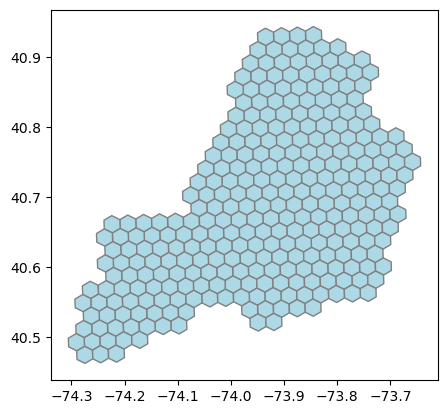

In [13]:
### WITH BUFFER RING AROUND THE CITY

LatLngPoly = h3.LatLngPoly

# Load and combine NYC polygons
gdf = gpd.read_file("nyc_boroughs.geojson")
geometry = gdf.dissolve().geometry.values[0]

# Handle MultiPolygon or Polygon uniformly
polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# Convert polygons to LatLngPoly for H3
latlng_polys = []
for poly in polygons:
    outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
    latlng_polys.append(h3.LatLngPoly(outer_ring))

# Collect all candidate H3 cells: base cells + neighbors
all_candidate_cells = set()
for shape in latlng_polys:
    base_cells = h3.polygon_to_cells(shape, res=7)
    candidate_cells = set(base_cells)
    for cell in base_cells:
        candidate_cells.update(h3.grid_ring(cell, 1))  # add neighbors (distance 1)
    all_candidate_cells.update(candidate_cells)

# Convert H3 cells to polygons for spatial filtering
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in all_candidate_cells
]

# Create GeoDataFrame of candidate hex cells
candidate_gdf = gpd.GeoDataFrame(
    {'h3_index': list(all_candidate_cells), 'geometry': polygons},
    crs='EPSG:4326'
)

# Create GeoDataFrame for original geometry
geom_gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')

# Filter hex cells intersecting the original polygon(s)
intersecting_hexes = candidate_gdf[candidate_gdf.geometry.intersects(geometry)]

# Add an extra ring of hexes around the current selection
core_hexes = set(intersecting_hexes['h3_index'])
buffer_hexes = set()
for h in core_hexes:
    buffer_hexes.update(h3.grid_ring(h, 1))
outer_ring_hexes = buffer_hexes - core_hexes

# Convert extra ring to geometries and add to intersecting_hexes
extra_polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in outer_ring_hexes
]
extra_gdf = gpd.GeoDataFrame(
    {'h3_index': list(outer_ring_hexes), 'geometry': extra_polygons},
    crs='EPSG:4326'
)
intersecting_hexes = pd.concat([intersecting_hexes, extra_gdf], ignore_index=True)

print(f"Total candidate hex cells: {len(all_candidate_cells)}")
print(f"Hex cells intersecting original polygon + buffer: {len(intersecting_hexes)}")

# Optional: Plot result
intersecting_hexes.plot(edgecolor='gray', facecolor='lightblue', figsize=(5,5))

In [14]:
# # Load and dissolve geometry
# gdf = gpd.read_file("nyc_tracts.geojson")
# geometry = gdf.dissolve().geometry.values[0]

# # Convert each polygon’s outer ring to a LatLngPoly
# polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# all_cells = set()
# for poly in polygons:
#     # Convert to [lat, lng] and wrap as LatLngPoly (no holes)
#     outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
#     shape = h3.LatLngPoly(outer_ring)
#     cells = h3.polygon_to_cells(shape, res=7)
#     all_cells.update(cells)

In [15]:
def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    ctx.add_basemap(ax, crs=df.crs, source=ctx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)


def plot_shape_and_cells(shape, res=7):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

In [16]:
# Convert each H3 cell index in intersecting_hexes to a Shapely Polygon
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in intersecting_hexes['h3_index']
]

# Create GeoDataFrame with same CRS
hex_gdf = gpd.GeoDataFrame(
    {'h3_index': intersecting_hexes['h3_index'], 'geometry': polygons},
    crs='EPSG:4326'
)

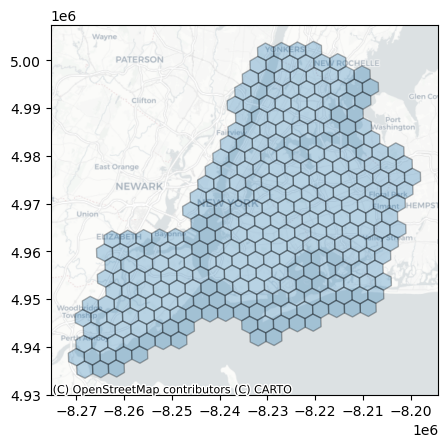

In [ ]:
hex_gdf_proj = hex_gdf.to_crs(epsg=3857)

# Plot with background
ax = hex_gdf_proj.plot(figsize=(5, 5), alpha=0.3, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=hex_gdf_proj.crs)

In [18]:
hex_gdf.head()

,h3_index,geometry
0,872a10014ffffff,"POLYGON ((-73.84371 40.90627, -73.8585 40.8997..."
1,872a100e3ffffff,"POLYGON ((-73.83836 40.75822, -73.85311 40.751..."
2,872a10018ffffff,"POLYGON ((-73.84103 40.83221, -73.8558 40.8256..."
3,872a10394ffffff,"POLYGON ((-73.83437 40.64736, -73.84908 40.640..."
4,872a100a0ffffff,"POLYGON ((-73.9338 40.90392, -73.94858 40.8973..."


# **GET POPULATION AND CENSUS DATA**

In [19]:
# --- Step 1: Load data ---
# Load census tracts shapefile
gdf = gpd.read_file("nyc_census/tl_2023_36_tract.shp")

# Load ACS data
df = pd.read_csv("nyc_census/ACSDT5Y2023.B01003-Data.csv", skiprows=1)
df["GEOID"] = df["Geography"].str.extract(r'(\d{11})')
df = df.rename(columns={"Estimate!!Total": "population"})

# Merge on GEOID
merged = gdf.merge(df[["GEOID", "population"]], on="GEOID", how="left")

# Drop missing geometries and populations
merged = merged[merged.geometry.notnull() & merged.population.notnull()]


In [20]:
# --- Step 2: Load NYC boroughs and filter ---
nyc_boroughs = gpd.read_file("nyc_boroughs.geojson")
nyc_boroughs = nyc_boroughs.to_crs(merged.crs)

# Filter tracts that intersect NYC boroughs
merged = merged[merged.intersects(nyc_boroughs.unary_union)].copy()

# --- Step 3: Calculate centroids ---
merged["centroid"] = merged.geometry.centroid
merged["lon"] = merged.centroid.x
merged["lat"] = merged.centroid.y

# --- Step 4: Remove mostly-water tracts ---
# Calculate tract area and intersection area
merged["tract_area"] = merged.geometry.area
intersection = gpd.overlay(merged, nyc_boroughs, how="intersection")
intersection["intersection_area"] = intersection.geometry.area

# Calculate percent overlap with borough land
area_df = intersection.groupby("GEOID")["intersection_area"].sum().reset_index()
merged = merged.merge(area_df, on="GEOID", how="left")
merged["percent_overlap"] = merged["intersection_area"] / merged["tract_area"]

# Keep only tracts with at least 5% overlap
tracts_filtered = merged[merged["percent_overlap"] > 0.05].copy()

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/1720800781.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = merged[merged.intersects(nyc_boroughs.unary_union)].copy()
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/1720800781.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["centroid"] = merged.geometry.centroid
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/1720800781.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["lon"] = merged.centroid.x
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35784/1720800781.py:11: UserWarning: Geometry is in a geographic CRS.

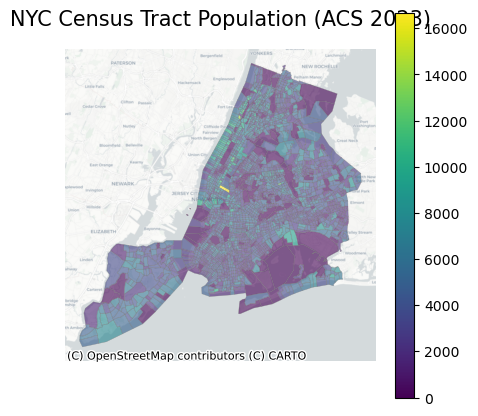

In [21]:
# --- Step 5: Plot with base map ---
tracts_filtered = tracts_filtered.to_crs(epsg=3857)  # Web Mercator for basemap
fig, ax = plt.subplots(figsize=(5, 5))
tracts_filtered.plot(
    column="population",
    cmap="viridis",
    linewidth=0.3,
    alpha=0.6,
    edgecolor="gray",
    legend=True,
    ax=ax
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("NYC Census Tract Population (ACS 2023)", fontsize=15)
ax.axis("off")
plt.show()

In [22]:
# Project to a CRS suitable for centroid computation
tracts_projected = tracts_filtered.to_crs(epsg=2263)  # NY State Plane East

# Compute centroids
tracts_projected["centroid_geom"] = tracts_projected.geometry.centroid

# Reproject back to WGS84 (if needed)
tracts_projected = tracts_projected.to_crs(epsg=4326)
tracts_projected["centroid_geom"] = tracts_projected["centroid_geom"].to_crs(epsg=4326)

# Select relevant columns
population_gdf = tracts_projected[["GEOID", "population", "geometry", "centroid_geom"]].copy()

# Rename for clarity
population_gdf = population_gdf.rename(columns={"geometry": "tract_geometry", "centroid_geom": "tract_centroid"})

population_gdf.head()


,GEOID,population,tract_geometry,tract_centroid
0,36081003400,2600.0,"POLYGON ((-73.8663 40.68319, -73.86549 40.6834...",POINT (-73.85819 40.68477)
1,36081003900,1474.0,"POLYGON ((-73.9433 40.76066, -73.94247 40.7619...",POINT (-73.94093 40.7628)
2,36081003600,3448.0,"POLYGON ((-73.8641 40.68237, -73.8637 40.68248...",POINT (-73.85682 40.68377)
3,36081003700,0.0,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",POINT (-73.94334 40.76242)
4,36081003800,2255.0,"POLYGON ((-73.8528 40.68425, -73.85196 40.6844...",POINT (-73.84749 40.6848)


# **COMBINE INTO ONE GDF**

In [23]:
hex_gdf_proj.head()

,h3_index,geometry
0,872a10014ffffff,"POLYGON ((-8220244.513 4998526.091, -8221890.8..."
1,872a100e3ffffff,"POLYGON ((-8219649.022 4976744.254, -8221290.2..."
2,872a10018ffffff,"POLYGON ((-8219946.297 4987624.063, -8221590.1..."
3,872a10394ffffff,"POLYGON ((-8219204.861 4960466.077, -8220842.3..."
4,872a100a0ffffff,"POLYGON ((-8230273.268 4998179.812, -8231918.2..."


In [24]:
# Convert POIs to GeoDataFrame in WGS84
gdf_pois = gpd.GeoDataFrame(
    poi_df,
    geometry=gpd.points_from_xy(poi_df.lon, poi_df.lat),
    crs="EPSG:4326"
)

# Reproject POIs to EPSG:3857 to match hex_gdf_proj
gdf_pois_proj = gdf_pois.to_crs(epsg=3857)

# Spatial join: find which POIs fall within each hex polygon
joined = gpd.sjoin(
    gdf_pois_proj,
    hex_gdf_proj[['h3_index', 'geometry']],
    how='inner',
    predicate='within'
)

# Count POIs per hex and type
counts = joined.groupby(['h3_index', 'type']).size().reset_index(name='count')

# Pivot to get one column per POI type with counts
counts_pivot = counts.pivot(index='h3_index', columns='type', values='count').fillna(0).reset_index()

# Merge counts back to hex_gdf_proj
hex_gdf_with_counts = hex_gdf_proj.merge(counts_pivot, on='h3_index', how='left').fillna(0)

# Convert counts to int (optional)
for col in counts['type'].unique():
    hex_gdf_with_counts[col] = hex_gdf_with_counts[col].astype(int)

hex_gdf_with_counts.head()

,h3_index,geometry,grocery,restaurant,warehouse
0,872a10014ffffff,"POLYGON ((-8220244.513 4998526.091, -8221890.8...",6,6,0
1,872a100e3ffffff,"POLYGON ((-8219649.022 4976744.254, -8221290.2...",5,19,0
2,872a10018ffffff,"POLYGON ((-8219946.297 4987624.063, -8221590.1...",0,1,0
3,872a10394ffffff,"POLYGON ((-8219204.861 4960466.077, -8220842.3...",0,0,0
4,872a100a0ffffff,"POLYGON ((-8230273.268 4998179.812, -8231918.2...",0,0,0


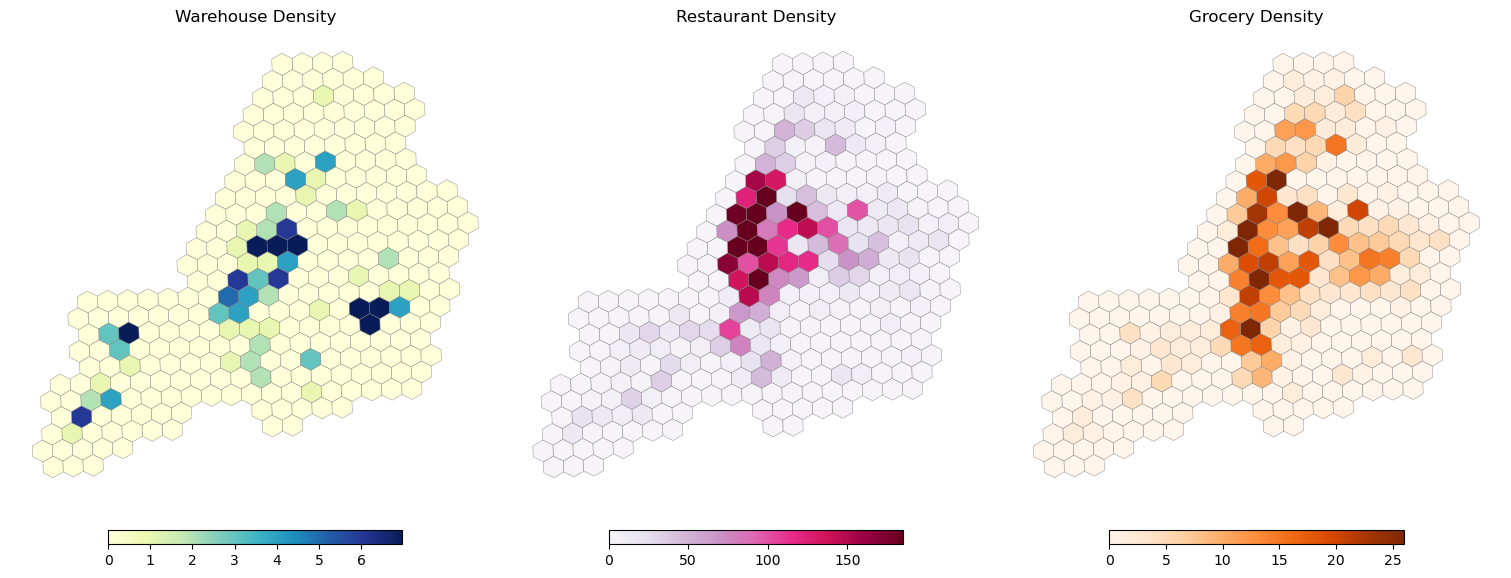

In [25]:
import matplotlib.pyplot as plt
import numpy as np

poi_types = ['warehouse', 'restaurant', 'grocery']
color_maps = {
    'warehouse': 'YlGnBu',
    'restaurant': 'PuRd',
    'grocery': 'Oranges'
}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)

for ax, poi_type in zip(axes, poi_types):
    if poi_type in hex_gdf_with_counts.columns:
        vmax = np.percentile(hex_gdf_with_counts[poi_type], 98)
        hex_gdf_with_counts['count'] = hex_gdf_with_counts[poi_type]
    else:
        vmax = 1
        hex_gdf_with_counts['count'] = 0

    hex_gdf_with_counts.plot(
        column='count',
        ax=ax,
        legend=True,
        cmap=color_maps[poi_type],
        edgecolor='gray',
        linewidth=0.3,
        vmax=vmax,
        legend_kwds={'shrink': 0.6, 'label': '', 'orientation': 'horizontal'},
        missing_kwds={"color": "#f0f0f0"},
    )
    ax.set_title(f'{poi_type.capitalize()} Density', fontsize=12)
    ax.axis('off')

plt.show()


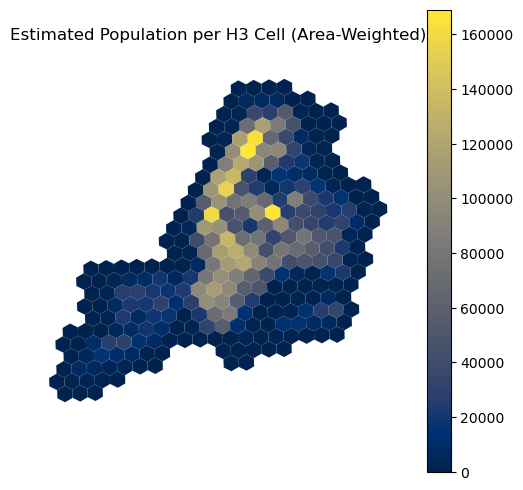

In [26]:
# Estimate population per hex cell using area-weighted interpolation approach

# Project CRS to metric for area calcs
hex_gdf_proj = hex_gdf_with_counts.to_crs(epsg=3857)
tracts_proj = population_gdf.copy()
tracts_proj = tracts_proj.set_geometry('tract_geometry').to_crs(epsg=3857)
tracts_proj['tract_area'] = tracts_proj.geometry.area

# Overlay intersection (tracts x hex)
intersections = gpd.overlay(tracts_proj, hex_gdf_proj, how='intersection')

# Calculate intersection area
intersections['intersection_area'] = intersections.geometry.area

# Calculate estimated population by proportion of area
intersections['pop_est'] = intersections['population'] * (
    intersections['intersection_area'] / intersections['tract_area']
)

# Aggregate population estimates by hex
hex_population = intersections.groupby('h3_index')['pop_est'].sum().reset_index()

# Merge into hex grid
hex_gdf_with_pop = hex_gdf_with_counts.merge(hex_population, on='h3_index', how='left')
hex_gdf_with_pop['pop_est'] = hex_gdf_with_pop['pop_est'].fillna(0)

# Plot result
hex_gdf_with_pop.to_crs(epsg=3857).plot(
    column='pop_est',
    cmap='cividis',
    legend=True,
    figsize=(6, 6),
    edgecolor='none'
)
plt.title("Estimated Population per H3 Cell (Area-Weighted)")
plt.axis('off')
plt.show()


In [27]:
hex_gdf_with_pop.head()

,h3_index,geometry,grocery,restaurant,warehouse,count,pop_est
0,872a10014ffffff,"POLYGON ((-8220244.513 4998526.091, -8221890.8...",6,6,0,6,53229.129176
1,872a100e3ffffff,"POLYGON ((-8219649.022 4976744.254, -8221290.2...",5,19,0,5,26583.074684
2,872a10018ffffff,"POLYGON ((-8219946.297 4987624.063, -8221590.1...",0,1,0,0,23706.860065
3,872a10394ffffff,"POLYGON ((-8219204.861 4960466.077, -8220842.3...",0,0,0,0,726.156415
4,872a100a0ffffff,"POLYGON ((-8230273.268 4998179.812, -8231918.2...",0,0,0,0,2291.371375


In [28]:
NUM_EXPRESS_PACK = 1400000 * 365
NUM_SCHEDULED_PACK = 2300000 * 365
NUM_TOTAL_PACK = NUM_EXPRESS_PACK + NUM_SCHEDULED_PACK
NUM_TOTAL_PACK

1350500000

In [29]:
unit_express_out = NUM_EXPRESS_PACK / (int(hex_gdf_with_pop['grocery'].sum()) + int(hex_gdf_with_pop['restaurant'].sum()))
unit_scheduled_out = NUM_SCHEDULED_PACK / int(hex_gdf_with_pop['warehouse'].sum())
unit_express_in = NUM_EXPRESS_PACK / int(hex_gdf_with_pop['pop_est'].sum())
unit_scheduled_in = NUM_SCHEDULED_PACK / int(hex_gdf_with_pop['pop_est'].sum())


In [30]:
final_hex_gdf = hex_gdf_with_pop.copy()

final_hex_gdf['express_in'] = unit_express_in * final_hex_gdf['pop_est']
final_hex_gdf['scheduled_in'] = unit_scheduled_in * final_hex_gdf['pop_est']
final_hex_gdf['express_out'] = unit_express_out * (final_hex_gdf['grocery'] + final_hex_gdf['restaurant'])
final_hex_gdf['scheduled_out'] = unit_scheduled_out * final_hex_gdf['warehouse']
final_hex_gdf

,h3_index,geometry,grocery,restaurant,warehouse,count,pop_est,express_in,scheduled_in,express_out,scheduled_out
0,872a10014ffffff,"POLYGON ((-8220244.513 4998526.091, -8221890.8...",6,6,0,6,53229.129176,3.193217e+06,5.246000e+06,7.072664e+05,0.0
1,872a100e3ffffff,"POLYGON ((-8219649.022 4976744.254, -8221290.2...",5,19,0,5,26583.074684,1.594719e+06,2.619896e+06,1.414533e+06,0.0
2,872a10018ffffff,"POLYGON ((-8219946.297 4987624.063, -8221590.1...",0,1,0,0,23706.860065,1.422175e+06,2.336431e+06,5.893887e+04,0.0
3,872a10394ffffff,"POLYGON ((-8219204.861 4960466.077, -8220842.3...",0,0,0,0,726.156415,4.356215e+04,7.156638e+04,0.000000e+00,0.0
4,872a100a0ffffff,"POLYGON ((-8230273.268 4998179.812, -8231918.2...",0,0,0,0,2291.371375,1.374594e+05,2.258262e+05,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
297,872a10199ffffff,"POLYGON ((-8230430.662 5003638.86, -8232076.94...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
298,872a10032ffffff,"POLYGON ((-8218647.068 5001311.811, -8220294.3...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
299,872a103a3ffffff,"POLYGON ((-8207499.459 4958146.318, -8209137.8...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
300,872a10701ffffff,"POLYGON ((-8246138.119 4970370.737, -8247774.4...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0


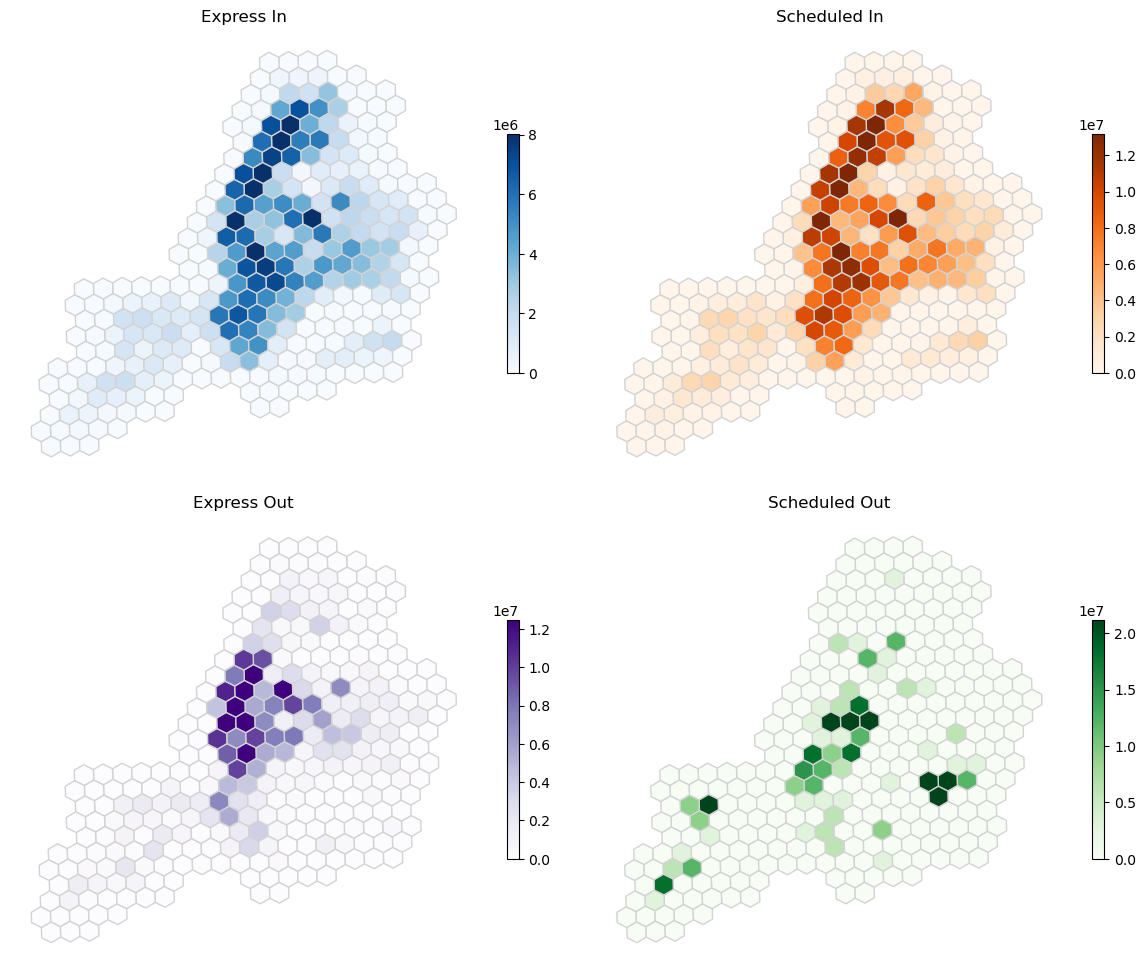

In [31]:
# Setup: 4 columns and distinct, attractive colormaps
columns = ['express_in', 'scheduled_in', 'express_out', 'scheduled_out']
titles = ['Express In', 'Scheduled In', 'Express Out', 'Scheduled Out']
colormaps = ['Blues', 'Oranges', 'Purples', 'Greens']  # visually distinct and intuitive

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Project once
gdf_proj = final_hex_gdf.to_crs(epsg=3857)

# Plot each with clipped vmax and unique colormap
for i, (col, title, cmap) in enumerate(zip(columns, titles, colormaps)):
    vmax = gdf_proj[col].quantile(0.98)
    gdf_proj.plot(
        column=col,
        cmap=cmap,
        legend=True,
        ax=axes[i],
        edgecolor='lightgray',
        vmax=vmax,
        legend_kwds={'shrink': 0.5}
    )
    axes[i].set_title(title, fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [32]:
final_hex_gdf['centroid'] = final_hex_gdf.geometry.centroid.to_crs(epsg=4326)

final_hex_gdf['centroid'] = final_hex_gdf['centroid'].apply(lambda pt: pt if isinstance(pt, Point) else Point(pt))

In [33]:
final_hex_gdf

,h3_index,geometry,grocery,restaurant,warehouse,count,pop_est,express_in,scheduled_in,express_out,scheduled_out,centroid
0,872a10014ffffff,"POLYGON ((-8220244.513 4998526.091, -8221890.8...",6,6,0,6,53229.129176,3.193217e+06,5.246000e+06,7.072664e+05,0.0,POINT (-73.84327 40.89392)
1,872a100e3ffffff,"POLYGON ((-8219649.022 4976744.254, -8221290.2...",5,19,0,5,26583.074684,1.594719e+06,2.619896e+06,1.414533e+06,0.0,POINT (-73.83792 40.7459)
2,872a10018ffffff,"POLYGON ((-8219946.297 4987624.063, -8221590.1...",0,1,0,0,23706.860065,1.422175e+06,2.336431e+06,5.893887e+04,0.0,POINT (-73.84059 40.81987)
3,872a10394ffffff,"POLYGON ((-8219204.861 4960466.077, -8220842.3...",0,0,0,0,726.156415,4.356215e+04,7.156638e+04,0.000000e+00,0.0,POINT (-73.83393 40.63506)
4,872a100a0ffffff,"POLYGON ((-8230273.268 4998179.812, -8231918.2...",0,0,0,0,2291.371375,1.374594e+05,2.258262e+05,0.000000e+00,0.0,POINT (-73.93333 40.89157)
...,...,...,...,...,...,...,...,...,...,...,...,...
297,872a10199ffffff,"POLYGON ((-8230430.662 5003638.86, -8232076.94...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,POINT (-73.93475 40.92862)
298,872a10032ffffff,"POLYGON ((-8218647.068 5001311.811, -8220294.3...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,POINT (-73.82892 40.91283)
299,872a103a3ffffff,"POLYGON ((-8207499.459 4958146.318, -8209137.8...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,POINT (-73.72881 40.61925)
300,872a10701ffffff,"POLYGON ((-8246138.119 4970370.737, -8247774.4...",0,0,0,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,POINT (-74.07581 40.70252)


# **FLOW MODELLING**

In [34]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    lat1, lat2 = radians(lat1), radians(lat2)
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

In [35]:
def get_flow_mat(hex_gdf, attraction_col, generation_col, beta):
    # Step 1: Prepare inputs
    g = hex_gdf[generation_col].values  # Generation vector
    a = hex_gdf[attraction_col].values   # Attraction vector
    centroids = final_hex_gdf['centroid'].values
    coords = hex_gdf['centroid'].apply(lambda p: (p.y, p.x)).tolist()  # (lat, lon)

    n = len(hex_gdf)
    G_total = g.sum()
    A_total = a.sum()

    # Optional: normalize to same total if necessary
    if not np.isclose(G_total, A_total):
        scale = G_total / A_total
        a = a * scale

    # Step 2: Compute distance matrix (in kilometers using haversine formula)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = haversine(*coords[i], *coords[j])
            else:
                D[i, j] = 0.1  # Avoid division by zero (use small non-zero distance)

    # Step 3: Impedance function
    F = np.exp(-beta * D)  # f(c_ij) = exp(-β * c_ij)

    # Step 4: Iterative Proportional Fitting to compute Ai and Bj
    Ai = np.ones(n)
    Bj = np.ones(n)

    for _ in range(500):  # max iterations
        Ai_new = 1 / (F @ (Bj * a))
        Bj_new = 1 / (F.T @ (Ai_new * g))
        
        if np.allclose(Ai, Ai_new, rtol=1e-5) and np.allclose(Bj, Bj_new, rtol=1e-5):
            break
        Ai, Bj = Ai_new, Bj_new

    # Step 5: Compute T_ij (flow matrix)
    T = np.outer(Ai * g, Bj * a) * F

    # Step 6: Convert to tidy DataFrame
    origin_ids = hex_gdf['h3_index'].values
    dest_ids = origin_ids

    od_df = pd.DataFrame([
    {
        'origin': origin_ids[i],
        'destination': dest_ids[j],
        'flow': T[i, j],
        'origin_centroid': centroids[i],
        'destination_centroid': centroids[j]
    }
    for i in range(n) for j in range(n) if T[i, j] > 0
    ])
    
    return od_df

In [36]:
# express_beta = 0.1805       # dist
# scheduled_beta = 0.0061     # dist
express_beta = 0.1108       # log dist
scheduled_beta = 0.0987     # log dist

express_od_df = get_flow_mat(final_hex_gdf, 'express_in', 'express_out', express_beta)
scheduled_od_df = get_flow_mat(final_hex_gdf, 'scheduled_in', 'scheduled_out', scheduled_beta)

In [37]:
express_od_df.to_csv('./express_od.csv')
scheduled_od_df.to_csv('./scheduled_od.csv')

Plotting 1578 OD lines...
Plotting 1255 OD lines...


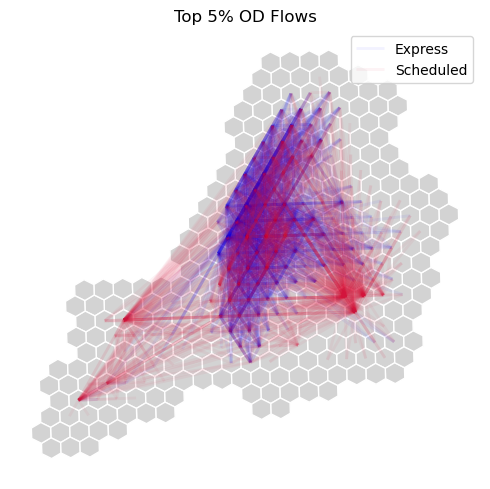

In [38]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# 1. Project hex grid to Web Mercator if not already
if final_hex_gdf.crs is None:
    final_hex_gdf.set_crs('EPSG:3857', inplace=True)
else:
    final_hex_gdf = final_hex_gdf.to_crs(epsg=3857)

# 2. Project centroids to EPSG:3857 (Web Mercator)
#    Convert from WGS84 string coords to shapely Points, then project
centroids_latlon = gpd.GeoSeries(final_hex_gdf['centroid'], crs='EPSG:4326')
centroids_projected = centroids_latlon.to_crs(epsg=3857)

# 3. Build lookup dictionary of projected centroids
final_hex_gdf['projected_centroid'] = centroids_projected.values
centroid_lookup = final_hex_gdf.set_index('h3_index')['projected_centroid'].to_dict()

# 4. Create LineStrings between origin and destination centroids
def make_line(row):
    origin = centroid_lookup.get(row['origin'])
    dest = centroid_lookup.get(row['destination'])
    if origin and dest and not origin.equals(dest):
        return LineString([origin, dest])
    return None

express_od_df['geometry'] = express_od_df.apply(make_line, axis=1)
od_gdf = gpd.GeoDataFrame(express_od_df.dropna(subset=['geometry']), geometry='geometry', crs='EPSG:3857')

# 5. Filter top 5% of flows to reduce clutter
od_gdf = od_gdf[od_gdf['flow'] >= od_gdf['flow'].quantile(0.96)]

print(f"Plotting {len(od_gdf)} OD lines...")

# 6. Plot
fig, ax = plt.subplots(figsize=(5, 5))
base = final_hex_gdf.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
od_gdf.plot(
    ax=base,
    linewidth=od_gdf['flow'] / od_gdf['flow'].max() + 2,
    alpha=0.05,
    color='blue',
    label='Express'
)

scheduled_od_df['geometry'] = scheduled_od_df.apply(make_line, axis=1)
od_gdf = gpd.GeoDataFrame(scheduled_od_df.dropna(subset=['geometry']), geometry='geometry', crs='EPSG:3857')

# 5. Filter top 5% of flows to reduce clutter
od_gdf = od_gdf[od_gdf['flow'] >= od_gdf['flow'].quantile(0.90)]

print(f"Plotting {len(od_gdf)} OD lines...")

# 6. Plot
# fig, ax = plt.subplots(figsize=(5, 5))
base = final_hex_gdf.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
od_gdf.plot(
    ax=base,
    linewidth=od_gdf['flow'] / od_gdf['flow'].max() + 2,
    alpha=0.05,
    color='crimson',
    label='Scheduled'
)
plt.legend()
plt.title('Top 5% OD Flows')
plt.axis('off')
plt.tight_layout()
plt.show()
